In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-emotion/test_sent_emo.csv
/kaggle/input/dataset-emotion/dev_sent_emo.csv
/kaggle/input/dataset-emotion/train_sent_emo.csv
/kaggle/input/dataset-glove/glove.6B.200d.txt
/kaggle/input/glovedataset/glove.6B.300d.txt
/kaggle/input/wordnet/data.adj
/kaggle/input/wordnet/LICENSE
/kaggle/input/wordnet/index.adj
/kaggle/input/wordnet/README
/kaggle/input/wordnet/verb.exc
/kaggle/input/wordnet/index.adv
/kaggle/input/wordnet/index.verb
/kaggle/input/wordnet/data.verb
/kaggle/input/wordnet/lexnames
/kaggle/input/wordnet/data.noun
/kaggle/input/wordnet/noun.exc
/kaggle/input/wordnet/index.noun
/kaggle/input/wordnet/adj.exc
/kaggle/input/wordnet/index.sense
/kaggle/input/wordnet/adv.exc
/kaggle/input/wordnet/cntlist.rev
/kaggle/input/wordnet/data.adv
/kaggle/input/wordnet/citation.bib


Importing Libraries

In [61]:
import pandas as pd
import numpy as np
import random
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
from nltk.corpus import wordnet

In [63]:
!pip install nltk
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4') 

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [64]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [65]:
import os
import shutil

# Create nltk_data/corpora/wordnet path
os.makedirs('/kaggle/working/nltk_data/corpora/wordnet', exist_ok=True)

# Copy all files from Kaggle input into the correct directory
source = '/kaggle/input/wordnet'
destination = '/kaggle/working/nltk_data/corpora/wordnet'

for filename in os.listdir(source):
    shutil.copy(os.path.join(source, filename), destination)

In [66]:
import nltk
nltk.data.path.append('/kaggle/working/nltk_data')

In [67]:
from nltk.corpus import wordnet as wn
print(wn.synsets('dog'))

[Synset('dog.n.01'), Synset('frump.n.01'), Synset('dog.n.03'), Synset('cad.n.01'), Synset('frank.n.02'), Synset('pawl.n.01'), Synset('andiron.n.01'), Synset('chase.v.01')]


## Augmentation

In [68]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ').lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(words, n):
    new_words = words.copy()
    eligible_words = [word for word in words if wordnet.synsets(word)]
    random.shuffle(eligible_words)
    replaced = 0
    for word in eligible_words:
        synonyms = get_synonyms(word)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words = [synonym if w == word else w for w in new_words]
            replaced += 1
        if replaced >= n:
            break
    return new_words

def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        word_to_insert = None
        for _ in range(10):  # Try 10 times to find a synonym
            random_word = random.choice(new_words)
            synonyms = get_synonyms(random_word)
            if synonyms:
                word_to_insert = random.choice(synonyms)
                break
        if word_to_insert:
            insert_pos = random.randint(0, len(new_words))
            new_words.insert(insert_pos, word_to_insert)
    return new_words

def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        if len(new_words) < 2:
            return new_words
        idx1, idx2 = random.sample(range(len(new_words)), 2)
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return new_words

def random_deletion(words, p=0.1):
    if len(words) == 1:
        return words
    return [word for word in words if random.uniform(0, 1) > p] or [random.choice(words)]

def eda(sentence, num_aug=1):
    sentence = re.sub(r'[^\w\s]', '', sentence.lower())
    words = sentence.split()
    if len(words) == 0:
        return []
    augmented_sentences = []
    for _ in range(num_aug):
        aug_type = random.choice(['sr', 'ri', 'rs', 'rd'])
        if aug_type == 'sr':
            new_words = synonym_replacement(words, max(1, len(words)//10))
        elif aug_type == 'ri':
            new_words = random_insertion(words, max(1, len(words)//10))
        elif aug_type == 'rs':
            new_words = random_swap(words, max(1, len(words)//10))
        elif aug_type == 'rd':
            new_words = random_deletion(words)
        augmented_sentences.append(' '.join(new_words))
    return augmented_sentences

* we have small dataset, so we're doing data augmentation

## Load and augment the dataset

In [69]:
train_df = pd.read_csv('/kaggle/input/dataset-emotion/train_sent_emo.csv')
test_df = pd.read_csv('/kaggle/input/dataset-emotion/test_sent_emo.csv')
val_df = pd.read_csv('/kaggle/input/dataset-emotion/dev_sent_emo.csv')

In [70]:
df = pd.concat([train_df, test_df, val_df], ignore_index=True)
df.shape

(13708, 11)

In [71]:
df.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


In [72]:
df.drop(columns=['Sr No.', 'Speaker', 'Sentiment', 'Dialogue_ID', 'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime'], inplace=True)

In [73]:
df.shape
df.head(2)

,Utterance,Emotion
0,also I was the point person on my companys tr...,neutral
1,You mustve had your hands full.,neutral


In [74]:
# Apply EDA on entire dataset, 2 augmented versions per sentence
augmented_data = {
    'Utterance': [],
    'Emotion': []
}

for _, row in df.iterrows():
    text = row['Utterance']
    label = row['Emotion']
    augmented_texts = eda(text, num_aug=2)
    for aug in augmented_texts:
        augmented_data['Utterance'].append(aug)
        augmented_data['Emotion'].append(label)

# Create augmented DataFrame
aug_df = pd.DataFrame(augmented_data)

# Combine with original data
df_augmented = pd.concat([df, aug_df], ignore_index=True)

# Check shapes
print("Original shape:", df.shape)
print("After EDA augmentation:", df_augmented.shape)

Original shape: (13708, 2)
After EDA augmentation: (41122, 2)


In [75]:
df_augmented.shape

(41122, 2)

In [76]:
df_augmented.isnull().sum()

Utterance    0
Emotion      0
dtype: int64

In [77]:
df_augmented.duplicated().sum()

4527

In [78]:
df_augmented.drop_duplicates(inplace=True)

In [79]:
df_augmented.shape

(36595, 2)

In [80]:
from sklearn.utils import shuffle

df_augmented = shuffle(df_augmented, random_state=24).reset_index(drop=True)

In [81]:
df_augmented.head()

,Utterance,Emotion
0,unaccompanied are you alone,neutral
1,but we pick once more we pick once more,joy
2,okay you can do it just open up put it your mouth,neutral
3,was that monica also true an,neutral
4,this what is ohh,surprise


In [82]:
df_augmented['Emotion'].value_counts()

Emotion
neutral     16934
joy          6170
anger        4550
surprise     3960
sadness      2903
disgust      1047
fear         1031
Name: count, dtype: int64

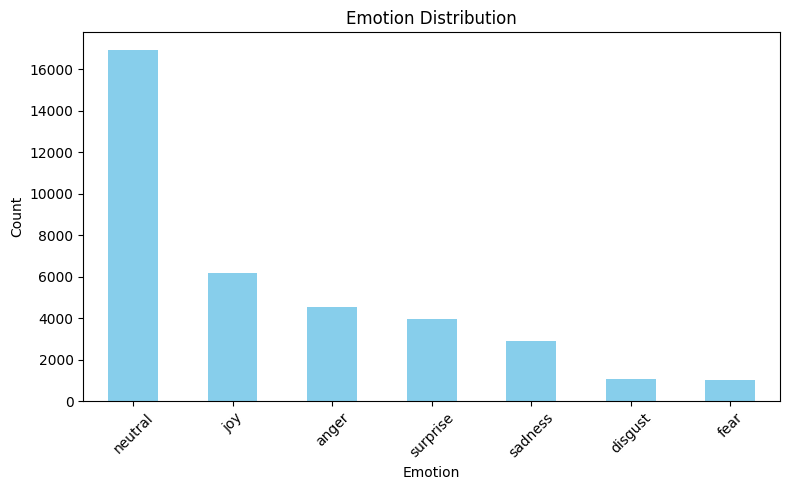

In [83]:
import matplotlib.pyplot as plt

# Get value counts
emotion_counts = df_augmented['Emotion'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* we have unbalanced dataset

In [84]:
df_augmented['Emotion'].value_counts().index

Index(['neutral', 'joy', 'anger', 'surprise', 'sadness', 'disgust', 'fear'], dtype='object', name='Emotion')

### Text Pre-processing

In [85]:
import regex as re
import string
# punc = string.punctuation
# punc

In [86]:
!pip install contractions

In [87]:
import contractions

In [88]:
# Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text)

In [89]:
## Text cleaning
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = expand_contractions(text)  # Expand contractions
    return text

In [90]:
# Apply preprocessing
df_augmented["clean_text"] = df_augmented["Utterance"].apply(clean_text)

In [91]:
df_augmented.head()

,Utterance,Emotion,clean_text
0,unaccompanied are you alone,neutral,unaccompanied are you alone
1,but we pick once more we pick once more,joy,but we pick once more we pick once more
2,okay you can do it just open up put it your mouth,neutral,okay you can do it just open up put it your mouth
3,was that monica also true an,neutral,was that monica also true an
4,this what is ohh,surprise,this what is ohh


In [92]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 94.7 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [93]:
import spacy

nlp = spacy.load("en_core_web_sm")

def lemmatize_spacy(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

text = "The striped bats are hanging on their feet for best"
print(lemmatize_spacy(text))

df_augmented["clean_text"] = df_augmented["clean_text"].apply(lemmatize_spacy)  # Apply lemmatization

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


the stripe bat be hang on their foot for good


In [94]:
df_augmented.head()

,Utterance,Emotion,clean_text
0,unaccompanied are you alone,neutral,unaccompanied be you alone
1,but we pick once more we pick once more,joy,but we pick once more we pick once more
2,okay you can do it just open up put it your mouth,neutral,okay you can do it just open up put it your mouth
3,was that monica also true an,neutral,be that monica also true an
4,this what is ohh,surprise,this what be ohh


In [95]:
# Apply Label Encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_augmented["emotion_label"] = label_encoder.fit_transform(df_augmented["Emotion"])

In [96]:
df_augmented.head()

,Utterance,Emotion,clean_text,emotion_label
0,unaccompanied are you alone,neutral,unaccompanied be you alone,4
1,but we pick once more we pick once more,joy,but we pick once more we pick once more,3
2,okay you can do it just open up put it your mouth,neutral,okay you can do it just open up put it your mouth,4
3,was that monica also true an,neutral,be that monica also true an,4
4,this what is ohh,surprise,this what be ohh,6


In [97]:
# Get the number of unique emotion classes
num_classes = df_augmented["emotion_label"].nunique()
print(f"Number of emotion classes: {num_classes}")  # Should be 7

Number of emotion classes: 7


In [98]:
import numpy as np
import pandas as pd
import re
import string
import contractions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler

In [99]:
# Train-Validation-Test Split
X = df_augmented["clean_text"]
y = df_augmented["emotion_label"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

### Feature Engineering

In [100]:
## Tokenization
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(X_train)
tokenizer.document_count
vocab_size = len(tokenizer.index_word) + 1
print(f"The vocab size is {vocab_size}")

The vocab size is 7525


In [101]:
# Determine max sequence length
max_len = max([len(text.split()) for text in df_augmented["clean_text"]])
print(f"Max sequence length: {max_len}")

Max sequence length: 76


In [102]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [103]:
X_train_seq[0]

[14, 31, 483, 3155, 392]

In [104]:
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, truncating='pre')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, truncating='pre')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, truncating='pre')

In [105]:
X_train_padded[0:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   14,   31,  483, 3155,  392]],
      dtype=int32)

In [106]:
# One-Hot Encoding of labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

### GloVe

In [107]:
## Glove
path_to_glove_file = '/kaggle/input/dataset-glove/glove.6B.200d.txt'
num_tokens = vocab_size
embedding_dim = 200
hits=0
misses=0
embedding_index = {}

In [108]:
with open(path_to_glove_file, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embedding_index[word] = coefs

print(f"Found {len(embedding_index)} word vectors")

# Create embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim ))

for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print(f"Converted {hits} word, missed {misses} words")

Found 400000 word vectors
Converted 6439 word, missed 1085 words


## Model Implementation

In [109]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### RNN

In [59]:
## RNN Model
from tensorflow.keras.layers import SimpleRNN
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], 
              input_length=max_len, trainable=False),
    SimpleRNN(128, activation='relu', return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
rnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [60]:
history = rnn_model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), epochs=150, 
                        batch_size=32, callbacks=[early_stopping])

Epoch 1/150
915/915 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4453 - loss: 1.6165 - val_accuracy: 0.4709 - val_loss: 1.5209
Epoch 2/150
915/915 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4782 - loss: 1.5015 - val_accuracy: 0.4881 - val_loss: 1.4384
Epoch 3/150
915/915 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4920 - loss: 1.4381 - val_accuracy: 0.4971 - val_loss: 1.4219
Epoch 4/150
915/915 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5084 - loss: 1.3758 - val_accuracy: 0.5146 - val_loss: 1.3494
Epoch 5/150
915/915 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5249 - loss: 1.3294 - val_accuracy: 0.5253 - val_loss: 1.3419
Epoch 6/150
915/915 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5399 - loss: 1.2680 - val_accuracy: 0.5433 - val_loss: 1.2868
Epoch 7/150
915/915 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5628 - loss: 1.2226 - val_accuracy: 0.5417 - val_loss: 1.2687
Epoch 8/150
915/915 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5728 - loss: 1.1765 - val_ac

In [57]:
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 78, 200)             │       1,483,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 128)                 │          42,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,635,671 (6.24 MB)

 Trainable params: 50,823 (198.53 KB)

 Non-trainable params: 1,483,200 (5.66 MB)

 Optimizer params: 101,648 (397.07 KB)

In [61]:
rnn_loss, rnn_acc = rnn_model.evaluate(X_test_padded, y_test)
print("RNN Test Accuracy: ", rnn_acc)

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6019 - loss: 1.1351
RNN Test Accuracy:  0.5878655314445496


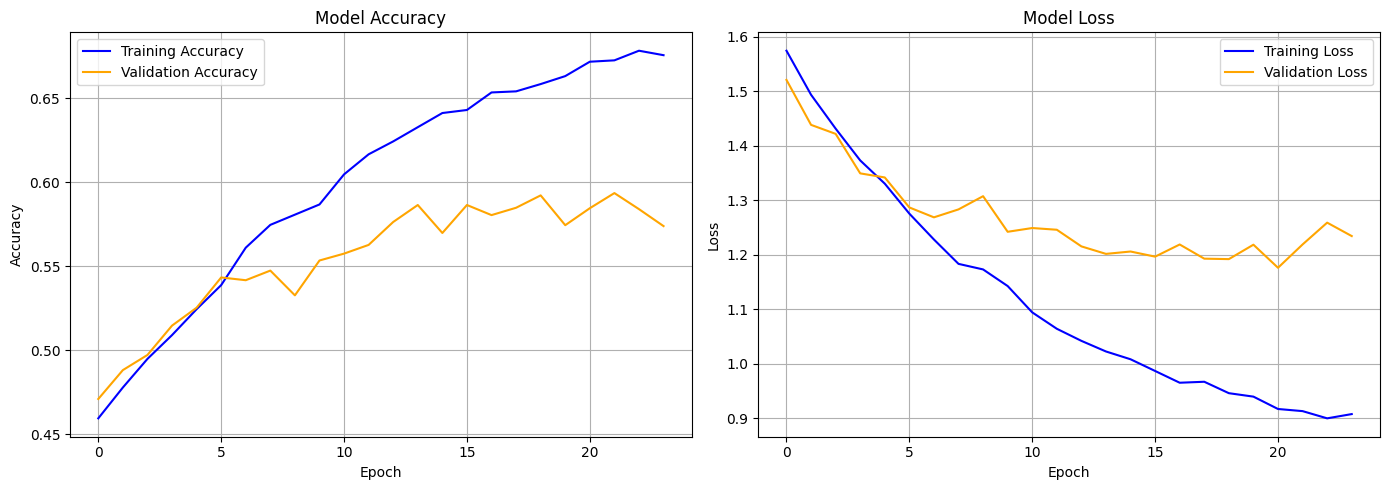

In [62]:
# Accuracy plot
import matplotlib.pyplot as plt

# Create subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot Loss
ax2.plot(history.history['loss'], label='Training Loss', color='blue')
ax2.plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### LSTM

In [63]:
## LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], 
              input_length=max_len, trainable=True),
    LSTM(128, return_sequences=False),  # No activation='relu'
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history1 = lstm_model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), epochs=150, batch_size=32, callbacks=[early_stopping])

Epoch 1/150
915/915 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.4697 - loss: 1.5452 - val_accuracy: 0.5340 - val_loss: 1.2969
Epoch 2/150
915/915 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5592 - loss: 1.2437 - val_accuracy: 0.6054 - val_loss: 1.1367
Epoch 3/150
915/915 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6550 - loss: 0.9781 - val_accuracy: 0.6502 - val_loss: 1.0067
Epoch 4/150
915/915 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7240 - loss: 0.7944 - val_accuracy: 0.6723 - val_loss: 0.9371
Epoch 5/150
915/915 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7684 - loss: 0.6596 - val_accuracy: 0.7057 - val_loss: 0.8795
Epoch 6/150
915/915 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8004 - loss: 0.5628 - val_accuracy: 0.7174 - val_loss: 0.8654
Epoch 7/150
915/915 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8221 - loss: 0.4917 - val_accuracy: 0.7308 - val_loss: 0.8517
Epoch 8/150
915/915 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8432 - loss: 0.4407 - val_acc

In [64]:
# Evaluate LSTM Model
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_padded, y_test)
print("LSTM Test Accuracy: ",lstm_acc)

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7306 - loss: 0.8558
LSTM Test Accuracy:  0.7286143898963928


In [65]:
lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 78, 200)             │       1,483,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         168,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,981,079 (19.00 MB)

 Trainable params: 1,660,359 (6.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,320,720 (12.67 MB)

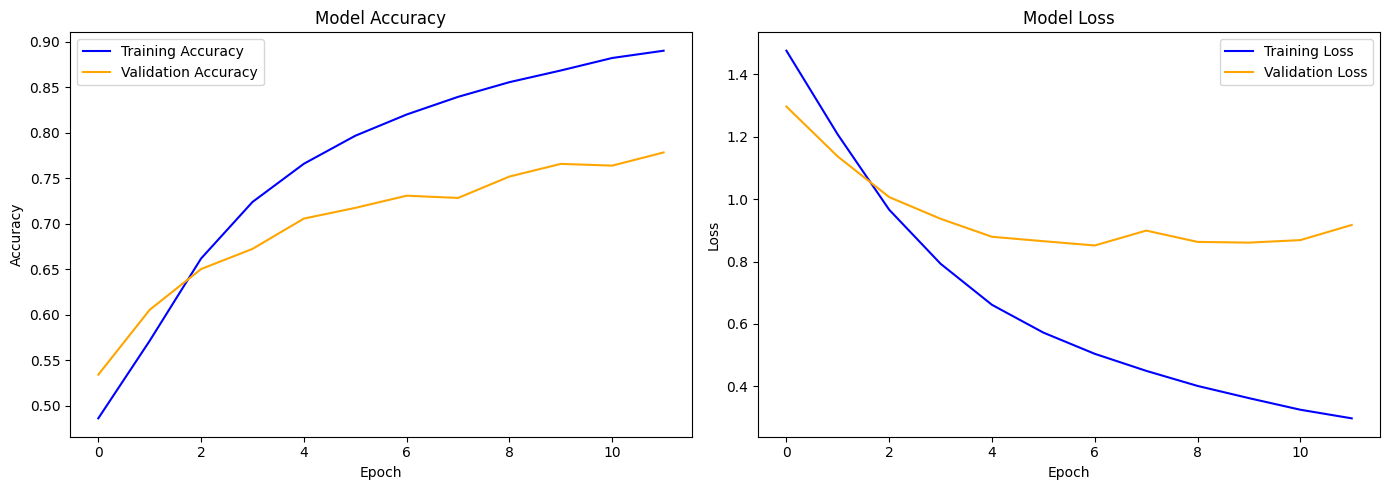

In [66]:
# Create subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
ax1.plot(history1.history['accuracy'], label='Training Accuracy', color='blue')
ax1.plot(history1.history['val_accuracy'], label='Validation Accuracy', color='orange')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot Loss
ax2.plot(history1.history['loss'], label='Training Loss', color='blue')
ax2.plot(history1.history['val_loss'], label='Validation Loss', color='orange')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

### BiLSTM

In [67]:
# BiLSTM Model
bilstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True),
    Bidirectional(LSTM(128, return_sequences=True)),  # First BiLSTM layer
    Bidirectional(LSTM(64, return_sequences=False)),  # Second BiLSTM layer
    Dropout(0.3),  # Reduced dropout
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile model with smaller learning rate
bilstm_model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

# Train model
history2 = bilstm_model.fit(X_train_padded, y_train,validation_data=(X_val_padded, y_val),epochs=150,batch_size=64,callbacks=[early_stopping])

Epoch 1/150
458/458 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.4567 - loss: 1.5711 - val_accuracy: 0.5212 - val_loss: 1.3435
Epoch 2/150
458/458 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5442 - loss: 1.3075 - val_accuracy: 0.5824 - val_loss: 1.2061
Epoch 3/150
458/458 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6315 - loss: 1.0771 - val_accuracy: 0.6242 - val_loss: 1.0862
Epoch 4/150
458/458 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6943 - loss: 0.8893 - val_accuracy: 0.6480 - val_loss: 1.0437
Epoch 5/150
458/458 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.7470 - loss: 0.7398 - val_accuracy: 0.6685 - val_loss: 0.9801
Epoch 6/150
458/458 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.7875 - loss: 0.6273 - val_accuracy: 0.6893 - val_loss: 0.9778
Epoch 7/150
458/458 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.8158 - loss: 0.5263 - val_accuracy: 0.7095 - val_loss: 0.9676
Epoch 8/150
458/458 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.8355 - loss: 0

In [68]:
# Evaluate BiLSTM Model
bilstm_loss, bilstm_acc = bilstm_model.evaluate(X_test_padded, y_test)
print("bilstm test accuracy: ", bilstm_acc)

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7229 - loss: 0.8980
bilstm test accuracy:  0.7234216928482056


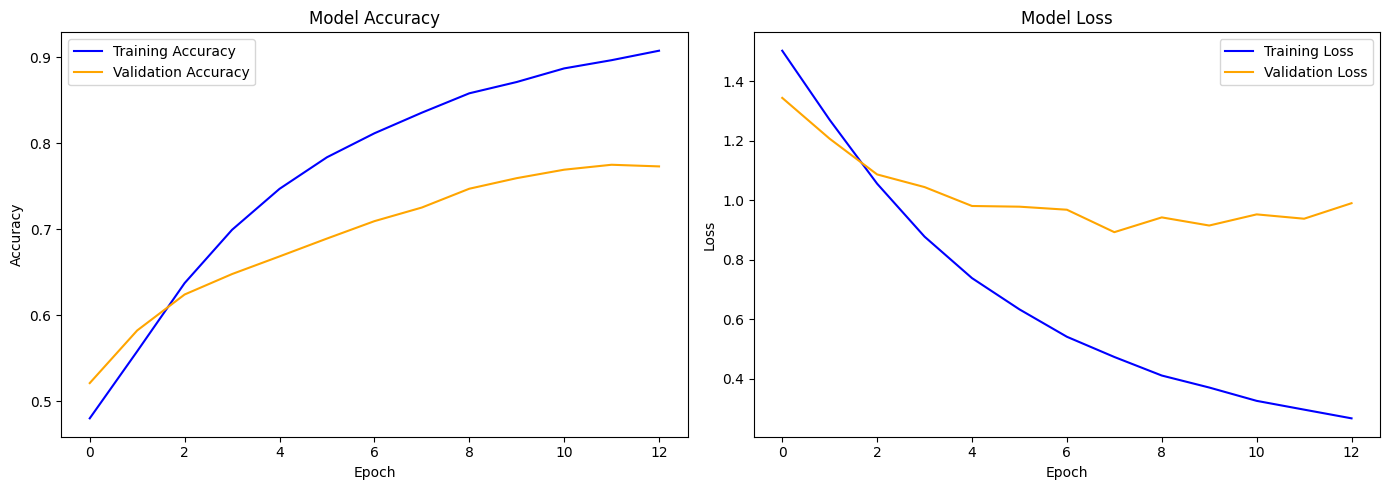

In [69]:
# Create subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
ax1.plot(history2.history['accuracy'], label='Training Accuracy', color='blue')
ax1.plot(history2.history['val_accuracy'], label='Validation Accuracy', color='orange')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot Loss
ax2.plot(history2.history['loss'], label='Training Loss', color='blue')
ax2.plot(history2.history['val_loss'], label='Validation Loss', color='orange')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [70]:
val_acc_rnn = max(history.history['val_accuracy'])
val_acc_lstm = max(history1.history['val_accuracy'])
val_acc_bilstm = max(history2.history['val_accuracy'])

models = ['RNN', 'LSTM', 'BiLSTM']
accuracies = [val_acc_rnn, val_acc_lstm, val_acc_bilstm]

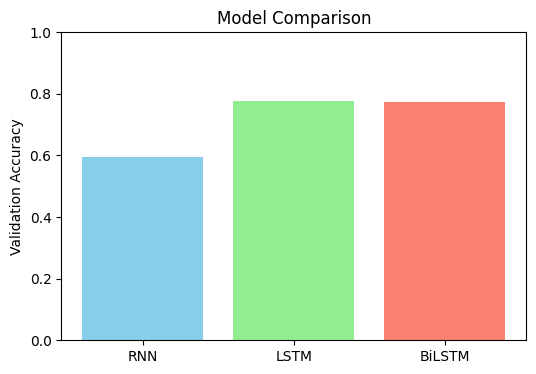

In [71]:
plt.figure(figsize=(6,4))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Model Comparison')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)  # Since accuracy is between 0 and 1
plt.show()

In [72]:
val_loss_rnn = max(history.history['val_loss'])
val_loss_lstm = max(history1.history['val_loss'])
val_loss_bilstm = max(history2.history['val_loss'])

models = ['RNN', 'LSTM', 'BiLSTM']
losses = [val_loss_rnn, val_loss_lstm, val_loss_bilstm]

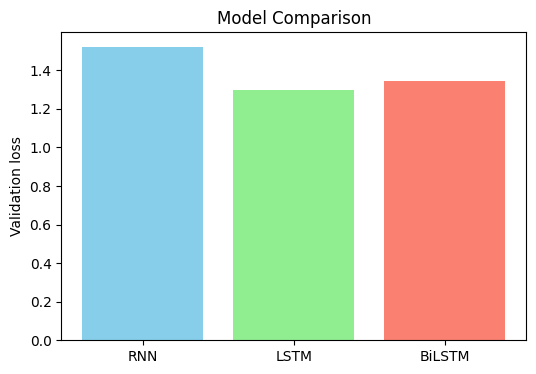

In [73]:
plt.figure(figsize=(6,4))
plt.bar(models, losses, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Model Comparison')
plt.ylabel('Validation loss')
# plt.ylim(0, 1) 
plt.show()

### Balancing the dataset using RandomOverSampler

In [110]:
# Random OverSampling

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_flat = X_train_padded.reshape((X_train_padded.shape[0], -1))
X_train_flat_resampled, y_train_resampled = ros.fit_resample(X_train_flat, y_train)
X_train_resampled = X_train_flat_resampled.reshape((-1, X_train_padded.shape[1]))

In [111]:
print(X_train_resampled.shape)
print(y_train_resampled.shape)

(94829, 76)
(94829, 7)


## Model Implementation after balancing

### RNN

In [130]:
## RNN Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SimpleRNN

rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], 
              input_length=max_len, trainable=True),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    BatchNormalization(),    # Batch Normalization to stabilize training
    Dropout(0.3),             
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')     # Output layer
])

rnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history3 = rnn_model.fit(X_train_resampled, y_train_resampled,validation_data=(X_val_padded, y_val),epochs=150,batch_size=32,callbacks=[early_stopping])

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2964/2964 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.2725 - loss: 1.9603 - val_accuracy: 0.2979 - val_loss: 1.6223
Epoch 2/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.6053 - loss: 1.1132 - val_accuracy: 0.4064 - val_loss: 1.4499
Epoch 3/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.7277 - loss: 0.7861 - val_accuracy: 0.4780 - val_loss: 1.3332
Epoch 4/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.7813 - loss: 0.6354 - val_accuracy: 0.5280 - val_loss: 1.2996
Epoch 5/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.8127 - loss: 0.5532 - val_accuracy: 0.5791 - val_loss: 1.2796
Epoch 6/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.8367 - loss: 0.4791 - val_accuracy: 0.5797 - val_loss: 1.2763
Epoch 7/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.8519 - loss: 0.4385 - val_accuracy: 0.6034 - val_loss: 1.2352
Epoch 8/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.8659 - loss: 0.40

In [131]:
rnn_loss, rnn_acc = rnn_model.evaluate(X_test_padded, y_test)
print("RNN Test Accuracy: ", rnn_acc)

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6407 - loss: 1.1546
RNN Test Accuracy:  0.6467213034629822


In [132]:
y_pred_prob = rnn_model.predict(X_val_padded)

# Convert predictions and true labels back to class labels
y_val_label = np.argmax(y_val, axis=1)
y_pred_label = np.argmax(y_pred_prob, axis=1)

# F1 Score
from sklearn.metrics import f1_score
f1_rnn = f1_score(y_val_label, y_pred_label, average='weighted')
print("f1 Score:", f1_rnn)

# Classification report
print(classification_report(y_val_label, y_pred_label))

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
f1 Score: 0.6439417882844266
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       455
           1       0.60      0.66      0.63       105
           2       0.38      0.57      0.46       103
           3       0.59      0.69      0.63       617
           4       0.79      0.62      0.70      1693
           5       0.55      0.62      0.58       290
           6       0.50      0.71      0.59       396

    accuracy                           0.64      3659
   macro avg       0.57      0.64      0.60      3659
weighted avg       0.67      0.64      0.64      3659



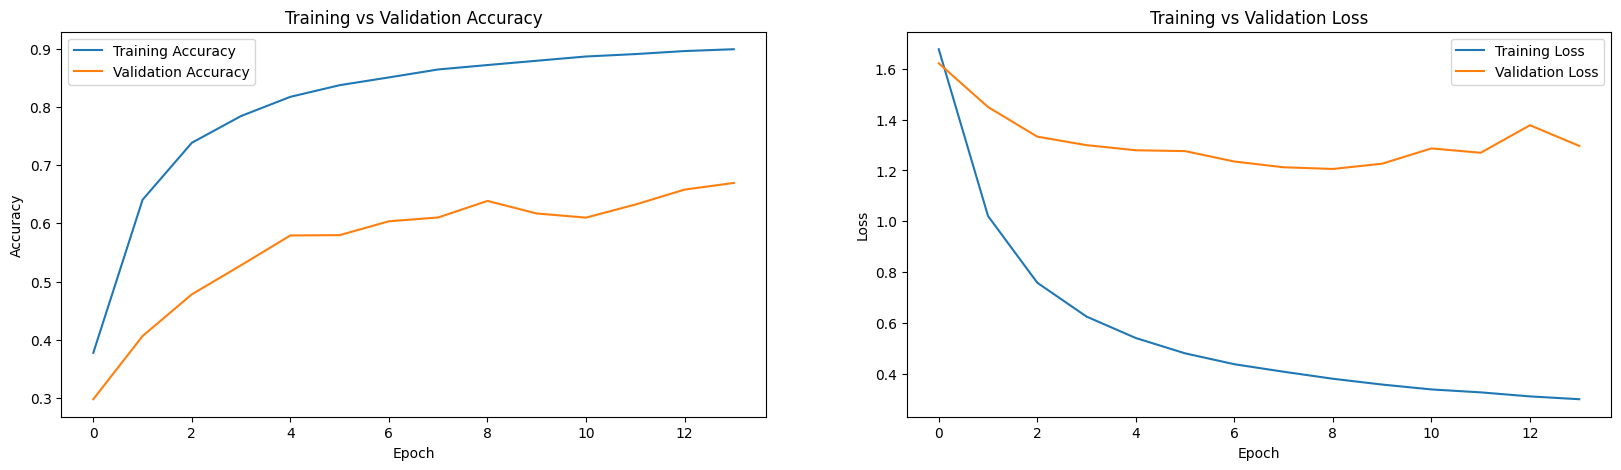

In [133]:
# Plot Accuracy and Loss
plt.figure(figsize=(20,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### LSTM

In [134]:
## LSTM
from tensorflow.keras.regularizers import l2
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], 
              input_length=max_len, trainable=True),
    LSTM(64, return_sequences=False),  
    Dropout(0.3),                      
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history4 = lstm_model.fit(
    X_train_resampled, y_train_resampled,validation_data=(X_val_padded, y_val),epochs=150,batch_size=32,
    callbacks=[early_stopping])

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2964/2964 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.4114 - loss: 1.5598 - val_accuracy: 0.5286 - val_loss: 1.2503
Epoch 2/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.7723 - loss: 0.6813 - val_accuracy: 0.6261 - val_loss: 1.0638
Epoch 3/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.8462 - loss: 0.4610 - val_accuracy: 0.6592 - val_loss: 0.9987
Epoch 4/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.8811 - loss: 0.3563 - val_accuracy: 0.6975 - val_loss: 0.9765
Epoch 5/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.9058 - loss: 0.2876 - val_accuracy: 0.7215 - val_loss: 0.9651
Epoch 6/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9199 - loss: 0.2471 - val_accuracy: 0.7204 - val_loss: 0.9817
Epoch 7/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9318 - loss: 0.2115 - val_accuracy: 0.7458 - val_loss: 0.9972
Epoch 8/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9381 - loss: 0.195

In [135]:
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_padded, y_test)
print("LSTM Test Accuracy: ", lstm_acc)

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7224 - loss: 0.9406
LSTM Test Accuracy:  0.728415310382843


In [136]:
y_pred_prob = lstm_model.predict(X_val_padded)

# Convert predictions and true labels back to class labels
y_val_label = np.argmax(y_val, axis=1)
y_pred_label = np.argmax(y_pred_prob, axis=1)

# F1 Score
from sklearn.metrics import f1_score
f1_lstm = f1_score(y_val_label, y_pred_label, average='weighted')
print("f1 Score:", f1_lstm)

# Classification report
print(classification_report(y_val_label, y_pred_label))

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
f1 Score: 0.7249580955192854
              precision    recall  f1-score   support

           0       0.65      0.73      0.69       455
           1       0.68      0.84      0.75       105
           2       0.55      0.72      0.62       103
           3       0.66      0.69      0.67       617
           4       0.85      0.71      0.77      1693
           5       0.67      0.77      0.72       290
           6       0.60      0.73      0.66       396

    accuracy                           0.72      3659
   macro avg       0.67      0.74      0.70      3659
weighted avg       0.74      0.72      0.72      3659



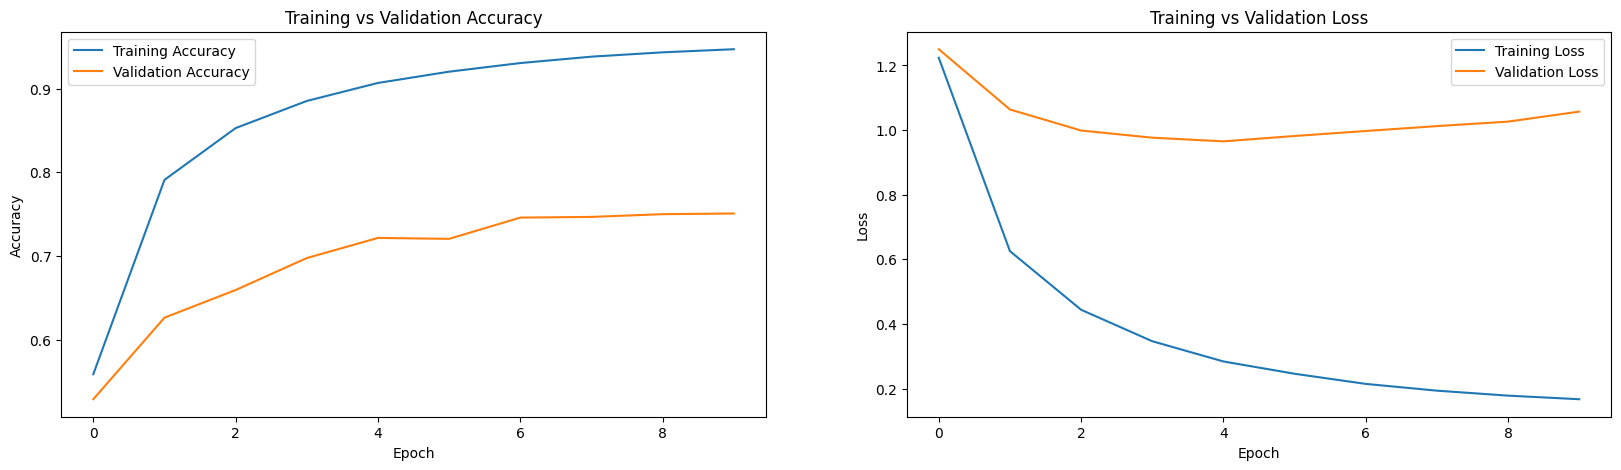

In [137]:
# Plot Accuracy and Loss
plt.figure(figsize=(20,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


### BiLSTM

In [112]:
## bilstm
from tensorflow.keras.layers import BatchNormalization
bilstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], 
              input_length=max_len, trainable=True),
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh')),
    Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

bilstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history5 = bilstm_model.fit(X_train_resampled, y_train_resampled,validation_data=(X_val_padded, y_val),
                            epochs=150,batch_size=64,callbacks=[early_stopping])

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1482/1482 ━━━━━━━━━━━━━━━━━━━━ 44s 27ms/step - accuracy: 0.3461 - loss: 1.7421 - val_accuracy: 0.3848 - val_loss: 1.5349
Epoch 2/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.6921 - loss: 0.8956 - val_accuracy: 0.5709 - val_loss: 1.2563
Epoch 3/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.7929 - loss: 0.6134 - val_accuracy: 0.5887 - val_loss: 1.1804
Epoch 4/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.8434 - loss: 0.4682 - val_accuracy: 0.6196 - val_loss: 1.1035
Epoch 5/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.8765 - loss: 0.3727 - val_accuracy: 0.6584 - val_loss: 1.1142
Epoch 6/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.9011 - loss: 0.2965 - val_accuracy: 0.7051 - val_loss: 1.0569
Epoch 7/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.9187 - loss: 0.2472 - val_accuracy: 0.7212 - val_loss: 0.9770
Epoch 8/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 39s 27ms/step - accuracy: 0.9315 - los

In [113]:
# Evaluate BiLSTM Model
bilstm_loss, bilstm_acc = bilstm_model.evaluate(X_test_padded, y_test)
print("bilstm test accuracy: ", bilstm_acc)

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7652 - loss: 0.9643
bilstm test accuracy:  0.7737705111503601


In [114]:
y_pred_proba = bilstm_model.predict(X_val_padded)

# Convert predictions and true labels back to class labels
y_val_labels = np.argmax(y_val, axis=1)
y_pred_labels = np.argmax(y_pred_proba, axis=1)

# F1 Score
from sklearn.metrics import f1_score
f1_bilstm = f1_score(y_val_labels, y_pred_labels, average='weighted')
print("f1 Score:", f1_bilstm)

# Classification report
print(classification_report(y_val_labels, y_pred_labels))

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
f1 Score: 0.7690915960115268
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       455
           1       0.78      0.75      0.77       105
           2       0.64      0.77      0.70       103
           3       0.70      0.78      0.74       617
           4       0.86      0.77      0.82      1693
           5       0.64      0.78      0.70       290
           6       0.68      0.76      0.72       396

    accuracy                           0.77      3659
   macro avg       0.72      0.76      0.74      3659
weighted avg       0.78      0.77      0.77      3659



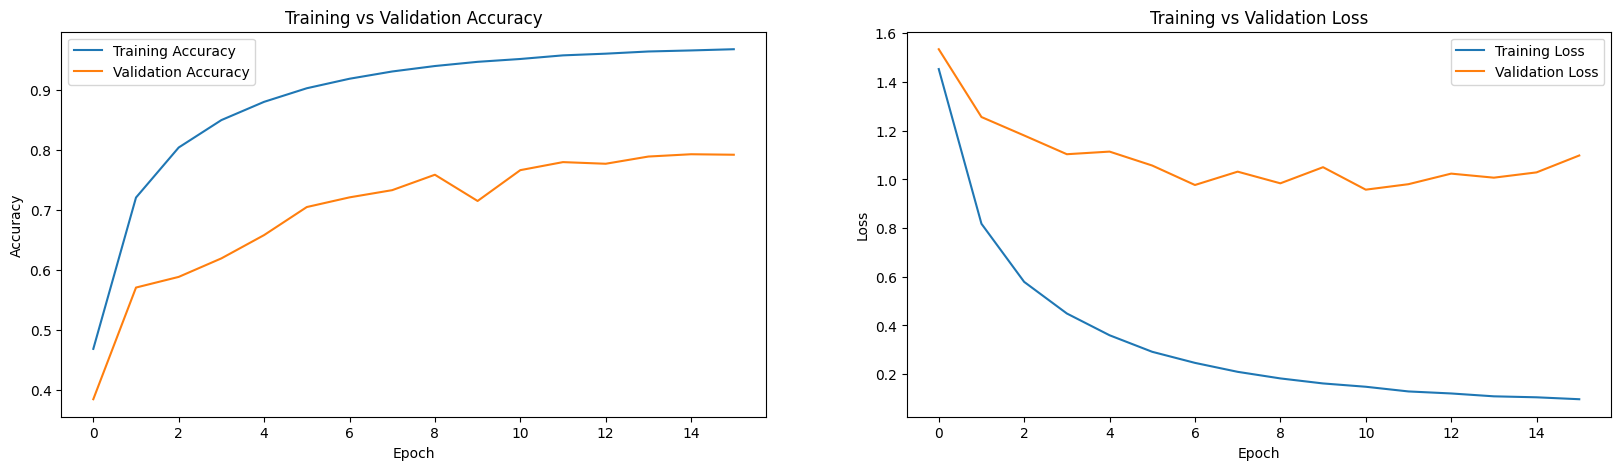

In [115]:
# Plot Accuracy and Loss
plt.figure(figsize=(20,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history5.history['accuracy'], label='Training Accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history5.history['loss'], label='Training Loss')
plt.plot(history5.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Stacked LSTM

In [116]:
## stacked_lstm_model
stacked_lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_len, trainable=True),
    LSTM(128, return_sequences=True, activation='tanh'),
    LSTM(64, return_sequences=False, activation='tanh'),
    
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])

stacked_lstm_model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_lstm = stacked_lstm_model.fit(X_train_resampled, y_train_resampled,validation_data=(X_val_padded, y_val),epochs=150,batch_size=64,callbacks=[early_stopping])

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1482/1482 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.3950 - loss: 1.6508 - val_accuracy: 0.3815 - val_loss: 1.6989
Epoch 2/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7511 - loss: 0.7342 - val_accuracy: 0.5316 - val_loss: 1.3412
Epoch 3/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8344 - loss: 0.4971 - val_accuracy: 0.6603 - val_loss: 1.0532
Epoch 4/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8832 - loss: 0.3542 - val_accuracy: 0.7130 - val_loss: 0.9835
Epoch 5/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9142 - loss: 0.2608 - val_accuracy: 0.7130 - val_loss: 1.0249
Epoch 6/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9350 - loss: 0.2023 - val_accuracy: 0.7423 - val_loss: 1.0629
Epoch 7/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9451 - loss: 0.1713 - val_accuracy: 0.7540 - val_loss: 0.9794
Epoch 8/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9555 - los

In [117]:
# Evaluate stacked Model
stacked_lstm_loss, stacked_lstm_acc = stacked_lstm_model.evaluate(X_test_padded, y_test)
print("stacked_lstm_model test accuracy: ", stacked_lstm_acc)

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7585 - loss: 1.0206
stacked_lstm_model test accuracy:  0.7592896223068237


In [118]:
y_pred = stacked_lstm_model.predict(X_val_padded)

# Convert predictions and true labels back to class labels
y_val_labels = np.argmax(y_val, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# F1 Score
f1_stacked_lstm = f1_score(y_val_labels, y_pred_labels, average='weighted')
print("f1_score:", f1_stacked_lstm)

# Classification report
print(classification_report(y_val_labels, y_pred_labels))

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
f1_score: 0.7561759848179588
              precision    recall  f1-score   support

           0       0.63      0.76      0.69       455
           1       0.71      0.83      0.76       105
           2       0.73      0.67      0.70       103
           3       0.73      0.75      0.74       617
           4       0.85      0.75      0.79      1693
           5       0.69      0.83      0.75       290
           6       0.69      0.74      0.71       396

    accuracy                           0.75      3659
   macro avg       0.72      0.76      0.74      3659
weighted avg       0.76      0.75      0.76      3659



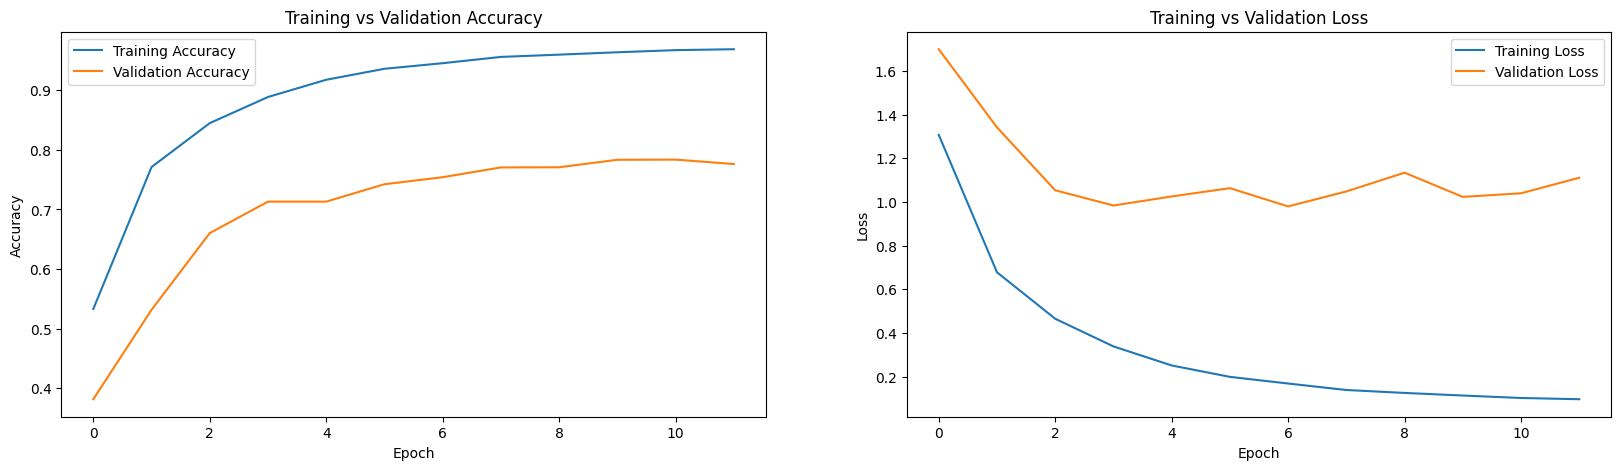

In [119]:
# Plot Accuracy and Loss
plt.figure(figsize=(20,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### GRU

In [120]:
# GRU model
gru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_len, trainable=True),
    GRU(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
gru_model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0005),metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history6 = gru_model.fit(X_train_resampled, y_train_resampled,validation_data=(X_val_padded, y_val),
                         epochs=150,batch_size=32,callbacks=[early_stopping])

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2964/2964 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.3635 - loss: 1.6907 - val_accuracy: 0.4143 - val_loss: 1.4475
Epoch 2/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.7355 - loss: 0.7890 - val_accuracy: 0.5627 - val_loss: 1.1805
Epoch 3/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.8261 - loss: 0.5266 - val_accuracy: 0.6365 - val_loss: 1.0501
Epoch 4/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.8761 - loss: 0.3777 - val_accuracy: 0.6920 - val_loss: 0.9923
Epoch 5/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.9034 - loss: 0.2966 - val_accuracy: 0.7122 - val_loss: 0.9738
Epoch 6/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.9210 - loss: 0.2452 - val_accuracy: 0.7177 - val_loss: 1.0192
Epoch 7/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.9312 - loss: 0.2100 - val_accuracy: 0.7475 - val_loss: 0.9752
Epoch 8/150
2964/2964 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.9421 - loss: 0.180

In [121]:
# Evaluate GRU Model
gru_loss, gru_acc = gru_model.evaluate(X_test_padded, y_test)
print("gru test accuracy: ", gru_acc)

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7150 - loss: 0.9443
gru test accuracy:  0.7144808769226074


In [122]:
y_pred = gru_model.predict(X_val_padded)

# Convert predictions and true labels back to class labels
y_val_labels = np.argmax(y_val, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# F1 Score
f1_gru = f1_score(y_val_labels, y_pred_labels, average='weighted')
print("f1_score:", f1_gru)

# Classification report
print(classification_report(y_val_labels, y_pred_labels))

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
f1_score: 0.713182602951161
              precision    recall  f1-score   support

           0       0.68      0.61      0.64       455
           1       0.63      0.85      0.72       105
           2       0.67      0.64      0.65       103
           3       0.66      0.68      0.67       617
           4       0.79      0.75      0.77      1693
           5       0.65      0.72      0.68       290
           6       0.61      0.70      0.65       396

    accuracy                           0.71      3659
   macro avg       0.67      0.71      0.68      3659
weighted avg       0.72      0.71      0.71      3659



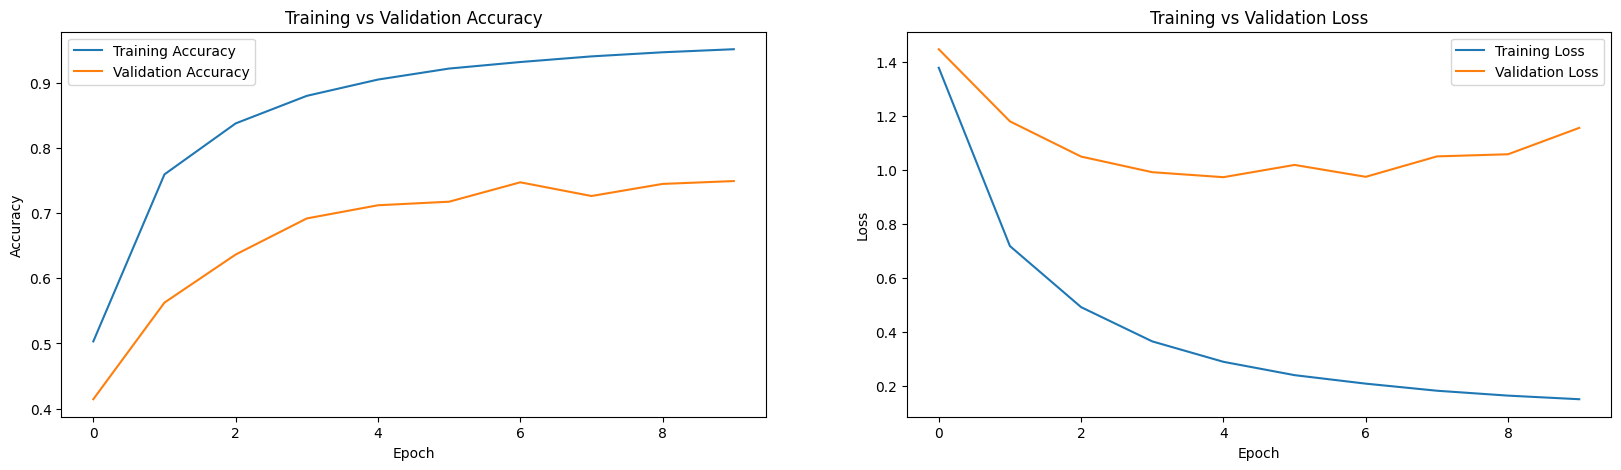

In [123]:
# Plot Accuracy and Loss
plt.figure(figsize=(20,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history6.history['accuracy'], label='Training Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history6.history['loss'], label='Training Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### BiGRU

In [124]:
# Bidirectional GRU model
bigru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_len, trainable=True),
    Bidirectional(GRU(128, return_sequences=True, activation='tanh')),
    Bidirectional(GRU(64, return_sequences=False, activation='tanh')),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
bigru_model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history7 = bigru_model.fit(X_train_resampled, y_train_resampled,validation_data=(X_val_padded, y_val),
                         epochs=150,batch_size=64,callbacks=[early_stopping])

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1482/1482 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.3919 - loss: 1.6437 - val_accuracy: 0.4761 - val_loss: 1.3394
Epoch 2/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.7659 - loss: 0.6977 - val_accuracy: 0.5928 - val_loss: 1.1563
Epoch 3/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.8581 - loss: 0.4283 - val_accuracy: 0.6934 - val_loss: 0.9742
Epoch 4/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.9045 - loss: 0.2956 - val_accuracy: 0.5961 - val_loss: 1.3563
Epoch 5/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.9280 - loss: 0.2224 - val_accuracy: 0.7275 - val_loss: 1.0190
Epoch 6/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.9457 - loss: 0.1738 - val_accuracy: 0.7344 - val_loss: 1.0097
Epoch 7/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.9532 - loss: 0.1475 - val_accuracy: 0.7543 - val_loss: 1.0903
Epoch 8/150
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.9587 - los

In [125]:
# Evaluate GRU Model
bigru_loss, bigru_acc = bigru_model.evaluate(X_test_padded, y_test)
print("gru test accuracy: ", bigru_acc)

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7026 - loss: 0.9525
gru test accuracy:  0.7030054926872253


In [126]:
y_pred = bigru_model.predict(X_val_padded)

# Convert predictions and true labels back to class labels
y_val_labels = np.argmax(y_val, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# F1 Score
f1_bigru = f1_score(y_val_labels, y_pred_labels, average='weighted')
print("f1_score:", f1_bigru)

# Classification report
print(classification_report(y_val_labels, y_pred_labels))

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
f1_score: 0.6950574373256817
              precision    recall  f1-score   support

           0       0.66      0.61      0.63       455
           1       0.70      0.77      0.73       105
           2       0.54      0.65      0.59       103
           3       0.69      0.60      0.64       617
           4       0.77      0.74      0.76      1693
           5       0.72      0.67      0.69       290
           6       0.52      0.74      0.61       396

    accuracy                           0.69      3659
   macro avg       0.66      0.68      0.66      3659
weighted avg       0.70      0.69      0.70      3659



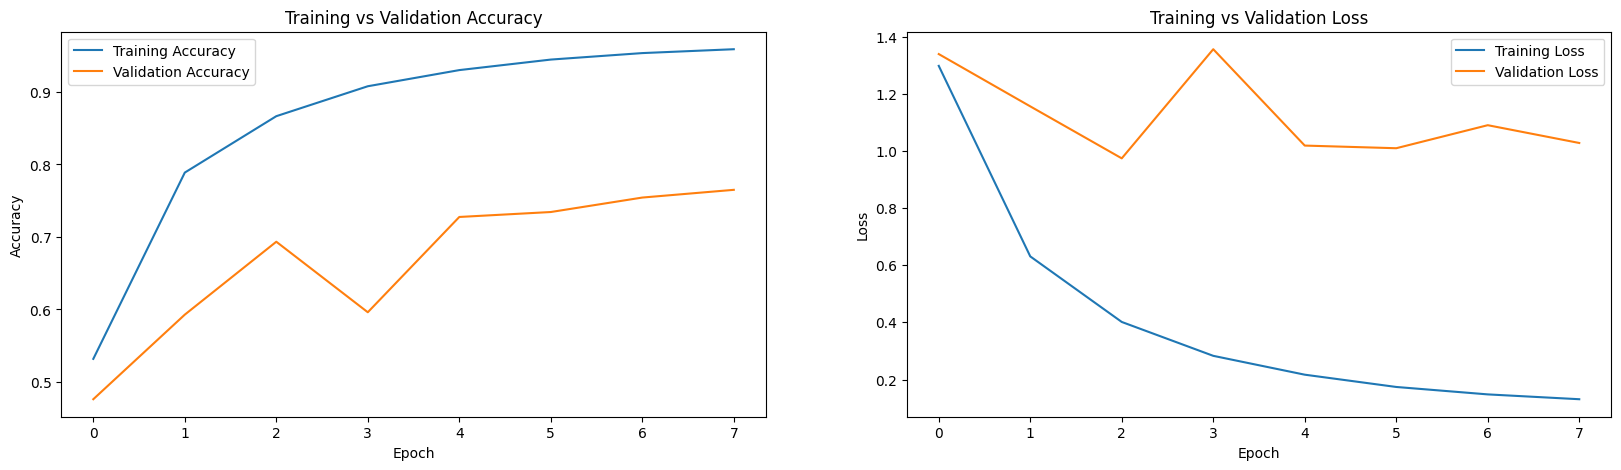

In [127]:
# Plot Accuracy and Loss
plt.figure(figsize=(20,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history7.history['accuracy'], label='Training Accuracy')
plt.plot(history7.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history7.history['loss'], label='Training Loss')
plt.plot(history7.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [138]:
val_acc_rnn = max(history3.history['val_accuracy'])
val_acc_lstm = max(history4.history['val_accuracy'])
val_acc_bilstm = max(history5.history['val_accuracy'])
# val_acc_stacked_lstm = max(history_lstm.history['val_accuracy'])
val_acc_gru = max(history6.history['val_accuracy'])
val_acc_bigru = max(history7.history['val_accuracy'])

model = ['RNN', 'LSTM', 'BiLSTM', 'GRU', 'BiGRU']
accuracy = [val_acc_rnn, val_acc_lstm, val_acc_bilstm, val_acc_gru, val_acc_bigru]

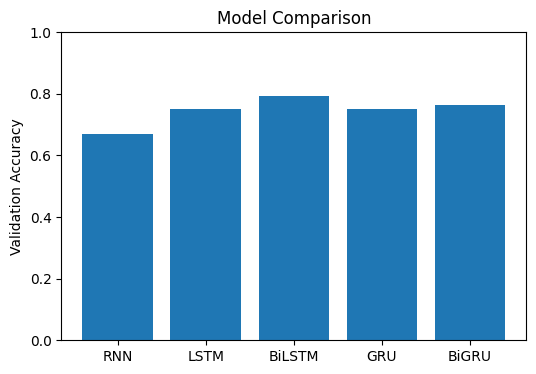

In [139]:
plt.figure(figsize=(6,4))
plt.bar(model, accuracy)
plt.title('Model Comparison')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
plt.show()

In [140]:
val_loss_rnn = max(history3.history['val_loss'])
val_loss_lstm = max(history4.history['val_loss'])
val_loss_bilstm = max(history5.history['val_loss'])
# val_loss_stacked_lstm = max(history_lstm.history['val_loss'])
val_loss_gru = max(history6.history['val_loss'])
val_loss_bigru = max(history7.history['val_loss'])

model = ['RNN', 'LSTM', 'BiLSTM', 'GRU', 'BiGRU']
loss = [val_loss_rnn, val_loss_lstm, val_loss_bilstm, val_loss_gru, val_loss_bigru]

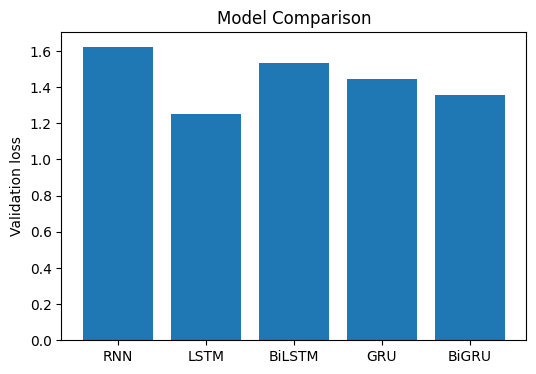

In [141]:
plt.figure(figsize=(6,4))
plt.bar(model, loss)
plt.title('Model Comparison')
plt.ylabel('Validation loss')
# plt.ylim(0, 1) 
plt.show()

In [143]:
# Final accuracies
train_acc_rnn = max(history3.history['accuracy'])
val_acc_rnn = max(history3.history['val_accuracy'])
# test_acc_rnn = rnn_acc
# f1_score_rnn = f1_rnn

train_acc_lstm = max(history4.history['accuracy'])
val_acc_lstm = max(history4.history['val_accuracy'])
# test_acc_lstm = lstm_acc
# f1_score_lstm = f1_lstm

train_acc_bilstm = max(history5.history['accuracy'])
val_acc_bilstm = max(history5.history['val_accuracy'])
# test_acc_bilstm = bilstm_acc
# f1_score_bilstm = f1_bilstm

# train_acc_stacked_lstm = max(history_lstm.history['accuracy'])
# val_acc_stacked_lstm = max(history_lstm.history['val_accuracy'])
# test_acc_stacked_lstm = stacked_lstm_acc
# f1_score_stacked_lstm = f1_stacked_lstm

train_acc_gru = max(history6.history['accuracy'])
val_acc_gru = max(history6.history['val_accuracy'])
# test_acc_gru = gru_acc
# f1_score_gru = f1_gru

train_acc_bigru = max(history7.history['accuracy'])
val_acc_bigru = max(history7.history['val_accuracy'])
# test_acc_bigru = bigru_acc
# f1_score_bigru = f1_bigru

data = {
    'Model': ['RNN', 'LSTM', 'BiLSTM', 'GRU', 'BiGRU'],
    'Train Accuracy': [train_acc_rnn, train_acc_lstm, train_acc_bilstm, train_acc_gru, train_acc_bigru],
    'Validation Accuracy': [val_acc_rnn, val_acc_lstm, val_acc_bilstm, val_acc_gru, val_acc_bigru],
    'Test Accuracy': [rnn_acc, lstm_acc, bilstm_acc, gru_acc,bigru_acc],
    'F1 Score': [f1_rnn, f1_lstm, f1_bilstm, f1_gru, f1_bigru]
}

result = pd.DataFrame(data)
result

,Model,Train Accuracy,Validation Accuracy,Test Accuracy,F1 Score
0,RNN,0.898902,0.669309,0.646721,0.643942
1,LSTM,0.947252,0.750752,0.728415,0.724958
2,BiLSTM,0.968153,0.793113,0.773771,0.769092
3,GRU,0.951871,0.749385,0.714481,0.713183
4,BiGRU,0.958947,0.764963,0.703005,0.695057


* Among the implemented architectures, BiLSTM performed best, achieving the highest validation accuracy of 79.31%, test accuracy of 77.38%, and F1 score of 76.91%.

## Predict Emotion for New Input

In [144]:
import pickle

In [145]:
# SAVE MODEL & PREPROCESSORS

# Save model (in new Keras format)
bilstm_model.save('emotion_saved_model.keras')

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [146]:
# Load model
from keras.models import load_model
model = load_model('emotion_saved_model.keras')

# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load label encoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

In [147]:
# Predict New Input

def predict_emotion(text):
    text_clean = clean_text(text)
    text_lemma = lemmatize_spacy(text_clean)
    seq = tokenizer.texts_to_sequences([text_lemma])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded)
    pred_class = np.argmax(pred, axis=1)
    emotion = label_encoder.inverse_transform(pred_class)               
    return emotion[0]
    # return emotion                               ## list

# Example prediction
new_text1 = "yeah you be but you decide to make salmon because you have some leave over at the restaurant"
print("Predicted Emotion:", predict_emotion(new_text1))

new_text2 = "Today is a great day!"
print("Predicted Emotion:", predict_emotion(new_text2))

new_text3 = "He drives so fast, it's scary."
print("Predicted Emotion:", predict_emotion(new_text3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Predicted Emotion: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Emotion: fear
